In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tempfile 
import pathlib
import pandas as pd
from hsc import HelmholtzDataset
from hsc.utility import xdmf_to_numpy
from hsc.domain_properties import read_from_json

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "Helvetica",
        "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",
    }
)

[arch-laptop:28383] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


Generate Dataset


In [2]:
data_directory = tempfile.TemporaryDirectory()
data_path = pathlib.Path(data_directory.name)

In [3]:
%cd ..

/home/jakob/master_workspace/Helmholtz-Sonic-Crystals


In [4]:
%run scripts/run_on_docker.py --out_dir={data_path} --input_code_file=scripts/convergence_study_adiabatic_layers.py

2024-04-24 17:41:28.971 | INFO     | __main__:<module>:186 - Starting with Namespace(input_parameter_file='scripts/domain.ini', input_code_file='scripts/convergence_study_adiabatic_layers.py', src_dir=PosixPath('/home/jakob/master_workspace/Helmholtz-Sonic-Crystals'), out_dir='/tmp/tmpijibwfqm', container_name='dolfinx', working_dir_container='/home/', is_complex=True, cleanup_docker=False, n_threads=1).
2024-04-24 17:41:28.974 | INFO     | __main__:<module>:190 - Started docker container dolfinx.
2024-04-24 17:41:29.106 | INFO     | __main__:<module>:196 - Successfully setup docker container.
2024-04-24 17:41:31.284 | INFO     | __main__:copy_to_container:107 - Copying /home/jakob/master_workspace/Helmholtz-Sonic-Crystals to /home/hsc (22 files).
2024-04-24 17:41:33.348 | INFO     | __main__:copy_to_container:114 - Copying /home/jakob/master_workspace/Helmholtz-Sonic-Crystals/pyproject.toml to /home.
2024-04-24 17:41:33.352 | INFO     | __main__:copy_to_container:114 - Copying /home/j

Processing /home
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for hsc: filename=hsc-1.0.0-py3-none-any.whl size=95972 sha256=644a6b31913e33558a616dd479ac97297ffe0b8d8af3349ce17b17b6f5f046e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-yta09r8n/wheels/dd/8a/5c/2ef7f30acf9c6d12ddeee95121b7e0e0d7d469c5bd226cfdcb
Successfully built hsc
  Attempting uninstall: hsc
    Found existing installation: hsc 1.0.0
    Uninstalling hsc-1.0.0:
      Successfully uninstalled hsc-1.0.0

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
 97%|█████████▋| 30/31 [00:13<00:00,  1.62it/s]

2024-04-24 17:41:51.731 | INFO     | __main__:<module>:212 - Finished simulation....
2024-04-24 17:41:51.763 | INFO     | __main__:<module>:223 - Finished copying files from container to /tmp/tmpijibwfqm.


100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


In [5]:
data_files = data_path.rglob('*.xdmf')

data_sets = []

for data_file in data_files:
    data_sets.append(HelmholtzDataset.from_xdmf_file(data_file))
print(f"Dataset contains a total of {len(data_sets)} datasets.")

Dataset contains a total of 31 datasets.


In [6]:
performances = pd.DataFrame()

for dataset in data_sets:
    # only get values inside the simulation domain
    cs = dataset.description.crystal.grid_size
    inside_indices =  np.greater_equal(dataset.x[:, 0], -cs / 2) & np.less_equal(dataset.x[:, 0], 9.5 * cs)
    dataset.x = dataset.x[inside_indices]
    dataset.p = dataset.p.squeeze()[inside_indices]
    
    difference = dataset.p.squeeze() - np.exp(1j * dataset.description.ks[0] * dataset.x[:, 0])

    real_mean_l1 = np.mean(np.abs(np.real(difference)))
    imag_mean_l1 = np.mean(np.abs(np.imag(difference)))
    
    performance = pd.DataFrame({
        "real_l1": [real_mean_l1],
        "imag_l1": [imag_mean_l1],
        "elements_per_lambda": [dataset.description.elements_per_lambda],
        "degree": [dataset.description.absorber.degree],
        "depth": [dataset.description.absorber.depth]
    })
    performances = pd.concat([performance, performances], ignore_index=True)
performances["n_lambda"] = performances["depth"] / (343. / 10000)

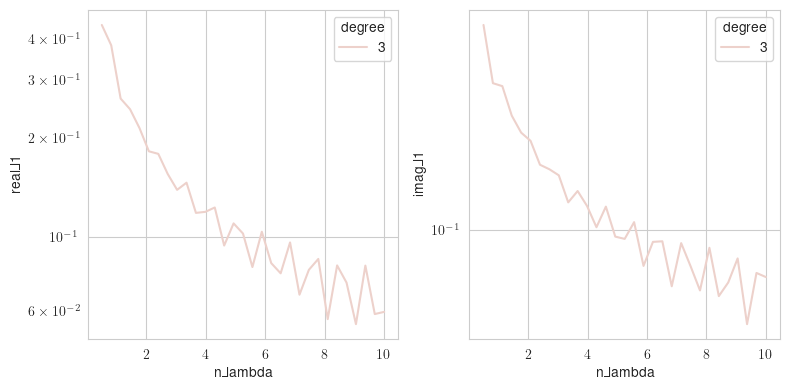

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

sns.lineplot(performances, x='n_lambda', y='real_l1', hue='degree', ax=axs[0])
sns.lineplot(performances, x='n_lambda', y='imag_l1', hue='degree', ax=axs[1])

for ax in axs.flatten():
    ax.set_yscale('log')
fig.tight_layout()

In [8]:
data_directory.cleanup()